In [1]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install stable_baselines3
!pip install numpy --upgrade 

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0)
ERROR: No matching distribution found for tensorflow==2.3.0


In [2]:
from gym import Env
from gym.spaces import Discrete, Box
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt
import numpy as np
import math
import gym
import stable_baselines3.common.env_checker
import random
import statistics
from os import path
from gym import spaces
from floris.tools.visualization import visualize_cut_plane

In [3]:
class wind_farm(gym.Env):
    global a1,a2,p1,p2
    a1=[]
    a2=[]
    p1=[]
    p2=[]
    def __init__(self):
        # Actions we can take are Absolute Angle Representation (theta(0-360 deg))
        self.action_space = Box(low=np.array([0,0]),high=np.array([360,360]))
        # dataframe least and highest values
        self.observation_space = Box(low=np.array([0,1,1,0,-1,-0.5]), high=np.array([360,18,18,1,1.5,0.5]))
        # Set state space
        n=2
        self.state = np.array([random.randint(0,n-1),random.sample(range(1,18),2),random.sample(range(0,360),2)],dtype=object)

    
    def farm_power(self,wind_d,wind_s,s1,s2):
        
        
        fi = FlorisInterface("inputs/gch.yaml")
        
        fi.floris.solver

        # 2. Modify the inputs with a more complex wind turbine layout
        D = 126.0  # Design the layout based on turbine diameter
        x = [6 * D,0]
        y = [5 * D, 0]

        # Pass the new data to FlorisInterface
        fi.reinitialize(
            layout_x=x,
            layout_y=y,
            wind_directions=wind_d,
            wind_speeds=wind_s
        )

        yaw_angles_1 = np.zeros( (2, 1, 2) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and two turbines
        yaw_angles_1[0, :, 0] = s1+50         # yaw the first turbine s1+50 degrees
        yaw_angles_1[0, :, 1] = s2+50
        # 3. Calculate the velocities at each turbine for all atmospheric conditions
        a1.append(yaw_angles_1[0].reshape(2,))  
        fi.calculate_wake(yaw_angles=yaw_angles_1)

        # 4. Get the total farm power
        turbine_powers = fi.get_turbine_powers() / 1000.0  # Given in W, so convert to kW
        farm_power_baseline = np.sum(turbine_powers, 2)  # Sum over the third dimension
        
        # 5. Develop the yaw control settings
        yaw_angles_2 = np.zeros( (2, 1, 2) )  # Construct the yaw array with dimensions for two wind directions, one wind speed, and two turbines
        yaw_angles_2[0, :, 0] = s1         # yaw the first turbine s1 degrees
        yaw_angles_2[0, :, 1] = s2            # yaw the second turbine s2 degrees
        
        a2.append(yaw_angles_2[0].reshape(2,))  
        # 6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
        fi.calculate_wake(yaw_angles=yaw_angles_2)

        # 7. Get the total farm power
        turbine_powers = fi.get_turbine_powers() / 1000.0
        farm_power_yaw = np.sum(turbine_powers, 2)

        # 8. Compare farm power with and without wake steering
        print('farm_power_baseline : {}, farm_power_yaw : {}'.format(farm_power_baseline[0],farm_power_yaw[0]))
        p1.append(farm_power_baseline[0])
        p2.append(farm_power_yaw[0])
        if farm_power_baseline.all()>0:
            difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
        else:
            difference = 100 * (farm_power_yaw - farm_power_baseline)
        
        print('Predefined_yaw_angle list:',a1)
        print('Power generated list:',p1)
        x3 = a1
        y3 = p1
        plt.scatter(x3, y3, color ="green")
        plt.title('Scatter Plot of Power generated vs predefined_yaw_angle')
        plt.xlabel('yaw_angle')
        plt.ylabel('Power generated')
        plt.grid()
        plt.show()
        
        print('Changed_yaw_angle list:',a2)
        print('Power generated list:',p2)
        x4 = a2
        y4 = p2
        plt.scatter(x4, y4, color ="blue")
        plt.title('Scatter Plot of Power generated vs changed_yaw_angle')
        plt.xlabel('yaw_angle')
        plt.ylabel('Power generated')
        plt.grid()
        plt.show()
        
        power_list = [np.amax(farm_power_baseline[0]),np.amax(farm_power_yaw)]
        print('Power_list:',power_list)
        return power_list

    def step(self, action):
        global max_pow 
        max_pow=-1000
        speed = env.observation_space.sample()[1:3]
        # Apply action
        #Absolute angle representation formula
#         print(action)
#         print(action[0])
#         print(action[1])
        self.state1 = math.radians(action[0] - 1*math.radians(180))
        self.state2 = math.radians(action[1] - 2*math.radians(180))
        print('Predefined Yaw Angle 1:',self.state1+50)
        print('Predefined Yaw Angle 2:',self.state2+50)
        print('Changed Yaw Angle 1:',self.state1)
        print('Changed Yaw Angle 2:',self.state2)
        if self.state1 >= 0 and self.state2 >= 0: 
            r = env.farm_power(action,speed,self.state1,self.state2)
            if r[1]>=max_pow:
                #self.reward = env.farm_power(action,speed,self.state1,self.state2)
                self.reward = r[1]
                max_pow=r[1]
                self.baseline_power = r[0]
        #any angle negative,reward is negative
            else: 
                self.reward = -1 
                self.baseline_power = -1
        else:
            self.reward = -1
            self.baseline_power = -1
        # Check if optimization is done
        if self.time_length <= 0: 
            done = True
        else:
            done = False
        # Set placeholder for info
        info = {'power':self.baseline_power}
        
        # Return step information
        return self.observation_space.sample(), self.reward, done, info

    def render(self):
        # Implement viz
        pass
    
    #Assuming that the agent is coming back to original state
    def reset(self):
        self.time_length = 60
        return self.observation_space.sample()

In [4]:
env = wind_farm()
# stable_baselines3.common.env_checker.check_env(env , warn= True) 

C:\Users\manoh\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [5]:
from stable_baselines3.sac.policies import CnnPolicy, MlpPolicy, MultiInputPolicy
from stable_baselines3.sac.sac import SAC
from stable_baselines3 import A2C
import stable_baselines3.common.env_checker

__all__ = ["CnnPolicy", "MlpPolicy", "MultiInputPolicy", "SAC"]

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Predefined Yaw Angle 1: 55.100580018479945
Predefined Yaw Angle 2: 54.4210762197327
Changed Yaw Angle 1: 5.100580018479944
Changed Yaw Angle 2: 4.421076219732696
farm_power_baseline : [9852.63948378  373.30276769], farm_power_yaw : [9999.98334062 1241.38936992]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622])]
Power generated list: [array([9852.63948378,  373.30276769])]


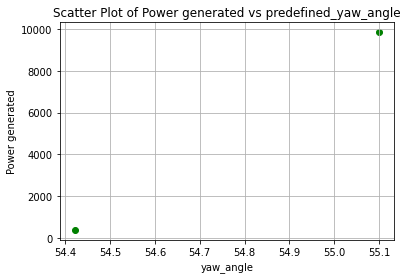

Changed_yaw_angle list: [array([5.10058002, 4.42107622])]
Power generated list: [array([9999.98334062, 1241.38936992])]


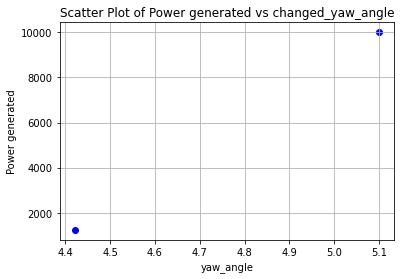

Power_list: [9852.639483781702, 9999.98616087771]
Predefined Yaw Angle 1: 50.250673522044885
Predefined Yaw Angle 2: 51.85158782625536
Changed Yaw Angle 1: 0.25067352204488674
Changed Yaw Angle 2: 1.8515878262553598
farm_power_baseline : [8980.61071451   62.95885782], farm_power_yaw : [10000.00216632   316.03237097]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782])]


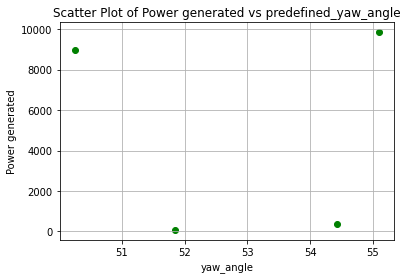

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097])]


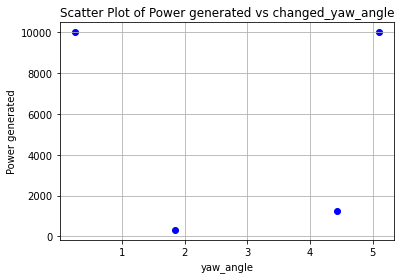

Power_list: [8980.610714507038, 10000.002166315497]
Predefined Yaw Angle 1: 51.25244593400217
Predefined Yaw Angle 2: 55.1942685832221
Changed Yaw Angle 1: 1.2524459340021663
Changed Yaw Angle 2: 5.194268583222094
farm_power_baseline : [10000.00147919  4895.81373983], farm_power_yaw : [9999.96037936 9999.99593533]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983])]


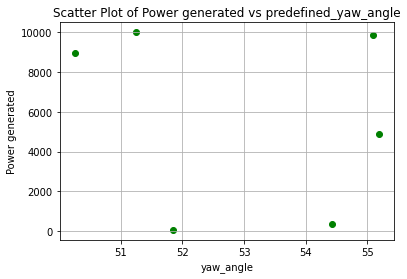

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533])]


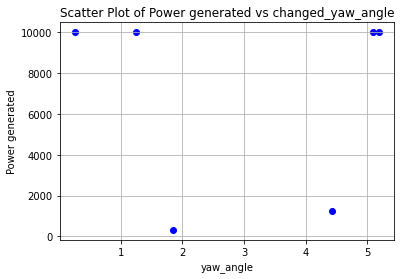

Power_list: [10000.0014791914, 9999.995935325838]
Predefined Yaw Angle 1: 52.40295922179173
Predefined Yaw Angle 2: 53.15005249577206
Changed Yaw Angle 1: 2.4029592217917344
Changed Yaw Angle 2: 3.1500524957720617
farm_power_baseline : [ 798.78763952 2989.97904037], farm_power_yaw : [2193.50226357 7622.87995836]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037])]


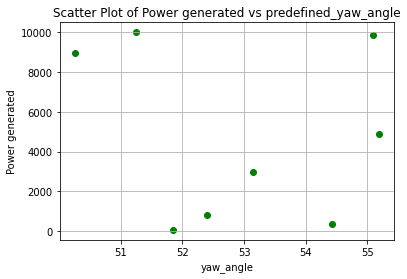

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836])]


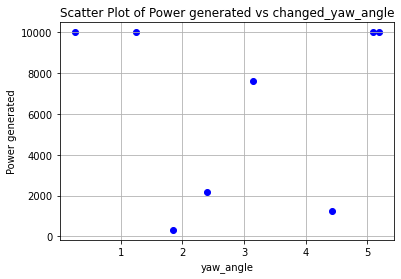

Power_list: [2989.9790403686766, 7639.0131972465115]
Predefined Yaw Angle 1: 54.88689809262413
Predefined Yaw Angle 2: 54.601726425956045
Changed Yaw Angle 1: 4.886898092624128
Changed Yaw Angle 2: 4.601726425956041
farm_power_baseline : [1114.92638672 7803.27930877], farm_power_yaw : [ 3222.20277809 10000.00178801]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877])]


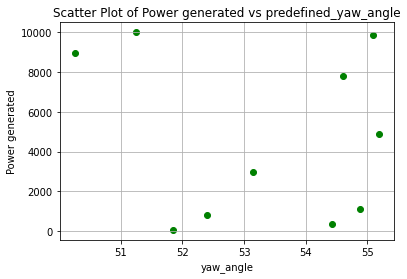

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801])]


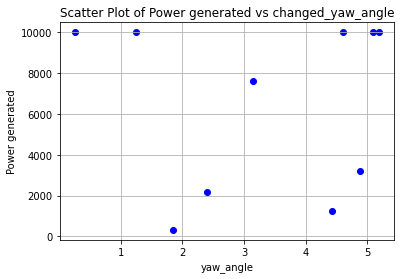

Power_list: [7803.279308772237, 10000.00178801372]
Predefined Yaw Angle 1: 51.45922441368028
Predefined Yaw Angle 2: 53.28083607584811
Changed Yaw Angle 1: 1.4592244136802788
Changed Yaw Angle 2: 3.280836075848109
farm_power_baseline : [7068.43080722 2831.98643301], farm_power_yaw : [9999.99672456 7120.10287677]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877]), array([7068.43080722, 2831.98643301])]


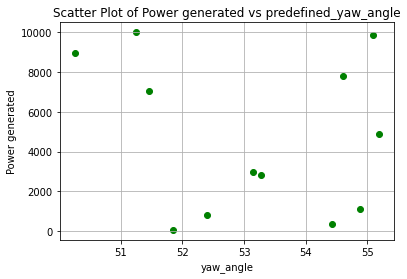

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677])]


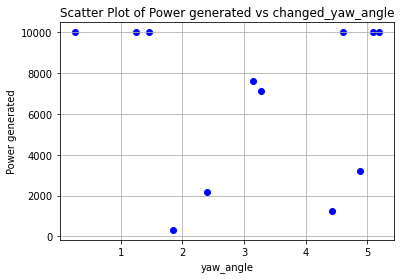

Power_list: [7068.430807217424, 9999.996724558468]
Predefined Yaw Angle 1: 50.279583966600946
Predefined Yaw Angle 2: 55.419972018238525
Changed Yaw Angle 1: 0.2795839666009463
Changed Yaw Angle 2: 5.419972018238527
farm_power_baseline : [1431.08085749  775.15516005], farm_power_yaw : [3731.52284542 2127.60893201]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877]), array([7068.43080722, 2831.98643301]), array([1431.08085749,  775.15516005])]


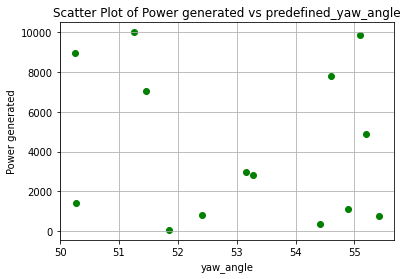

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201])]


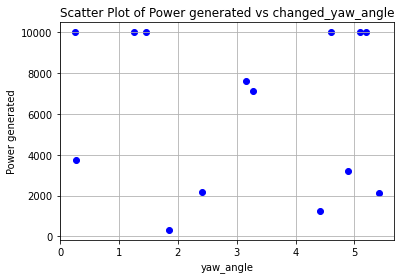

Power_list: [1431.0808574919406, 3747.295330801324]
Predefined Yaw Angle 1: 53.0407237185801
Predefined Yaw Angle 2: 55.85266379002697
Changed Yaw Angle 1: 3.040723718580095
Changed Yaw Angle 2: 5.852663790026971
farm_power_baseline : [ 220.28384724 9855.90859965], farm_power_yaw : [ 804.92368626 9999.99916709]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877]), array([7068.43080722, 2831.98643301]), array([1431.08085749,  775.15516005]), array([ 220.28384724, 9855.90859965])]


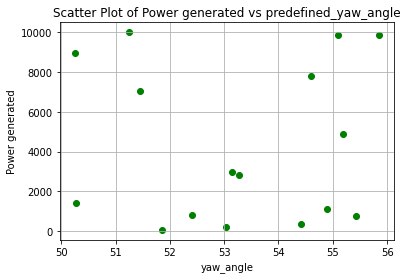

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709])]


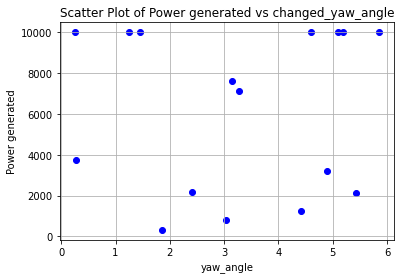

Power_list: [9855.90859964614, 10000.001892402424]
Predefined Yaw Angle 1: 55.25716164003559
Predefined Yaw Angle 2: 54.55514187953616
Changed Yaw Angle 1: 5.257161640035589
Changed Yaw Angle 2: 4.555141879536158
farm_power_baseline : [8344.57949259 5751.70333004], farm_power_yaw : [10000.00888139 10000.00447965]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877]), array([7068.43080722, 2831.98643301]), array([1431.08085749,  775.15516005]), array([ 220.28384724, 9855.90859965]), array

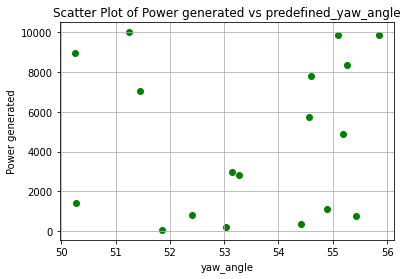

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965])]


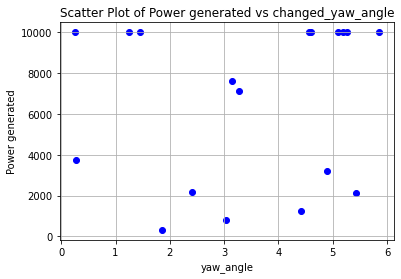

Power_list: [8344.579492592306, 10000.010110519306]
Predefined Yaw Angle 1: 53.37616297262935
Predefined Yaw Angle 2: 53.75320628471764
Changed Yaw Angle 1: 3.3761629726293525
Changed Yaw Angle 2: 3.7532062847176433
farm_power_baseline : [8873.91090916 3026.71342243], farm_power_yaw : [10000.01003185  7972.76852285]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877]), array([7068.43080722, 2831.98643301]), array([1431.08085749,  775.15516005]), array(

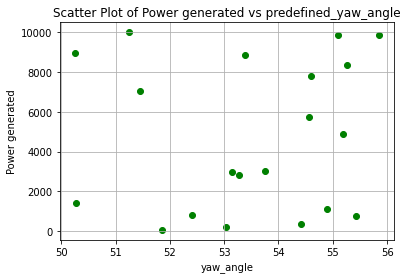

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285])]


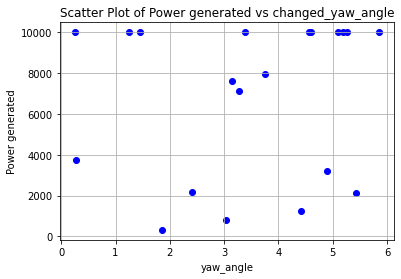

Power_list: [8873.91090916127, 10000.010471131593]
Predefined Yaw Angle 1: 56.14616156352708
Predefined Yaw Angle 2: 49.98910328829979
Changed Yaw Angle 1: 6.146161563527081
Changed Yaw Angle 2: -0.010896711700213599
Predefined Yaw Angle 1: 52.00749391466874
Predefined Yaw Angle 2: 55.99492612703348
Changed Yaw Angle 1: 2.0074939146687445
Changed Yaw Angle 2: 5.9949261270334775
farm_power_baseline : [3164.2132336  3250.09120952], farm_power_yaw : [8481.15089699 8690.54956524]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array

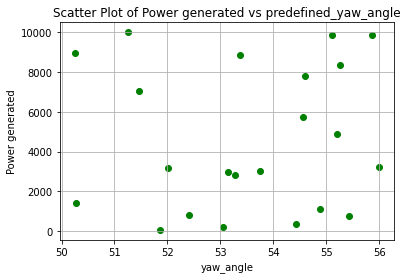

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285]), array([8481.15089699, 8690.54956524])]


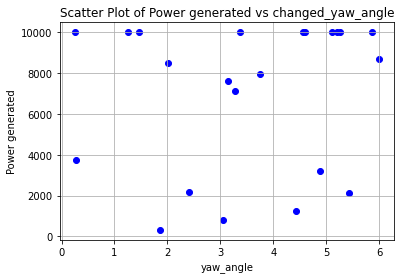

Power_list: [3250.0912095243066, 8737.494601663951]
Predefined Yaw Angle 1: 53.89562026641647
Predefined Yaw Angle 2: 55.193312508390754
Changed Yaw Angle 1: 3.895620266416469
Changed Yaw Angle 2: 5.193312508390755
farm_power_baseline : [7846.31963815   27.0924767 ], farm_power_yaw : [10000.00070502   224.24670203]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638672, 7803.27930877]), array([7068.430

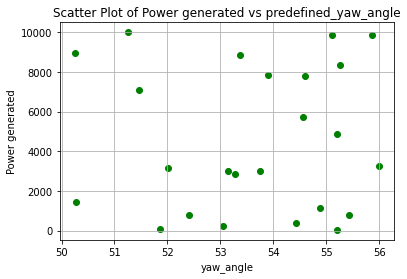

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285]), array([8481.15089699, 8690.54956524]), array([10000.00070502,   224.24670203])]


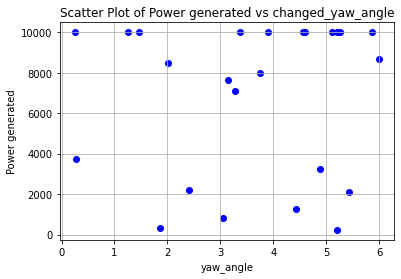

Power_list: [7846.319638146335, 10000.000907911197]
Predefined Yaw Angle 1: 54.918070393183505
Predefined Yaw Angle 2: 52.87493463936143
Changed Yaw Angle 1: 4.9180703931835055
Changed Yaw Angle 2: 2.8749346393614257
farm_power_baseline : [ 4130.57125633 10000.00115408], farm_power_yaw : [9999.9939672  9999.97184346]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.97904037]), array([1114.92638

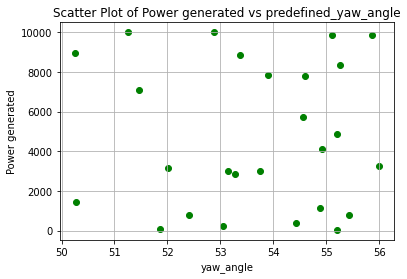

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285]), array([8481.15089699, 8690.54956524]), array([10000.00070502,   224.24670203]), array([9999.9939672 , 9999.97184346])]


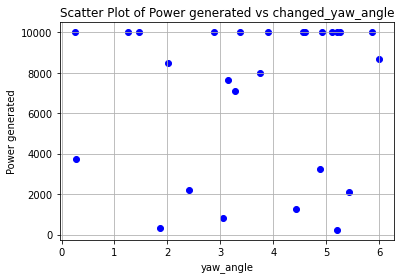

Power_list: [10000.001154075886, 9999.994334527852]
Predefined Yaw Angle 1: 55.27489243394112
Predefined Yaw Angle 2: 53.185625936348906
Changed Yaw Angle 1: 5.274892433941118
Changed Yaw Angle 2: 3.185625936348904
farm_power_baseline : [  0.         864.77797832], farm_power_yaw : [   0.         2499.78687981]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.81373983]), array([ 798.78763952, 2989.

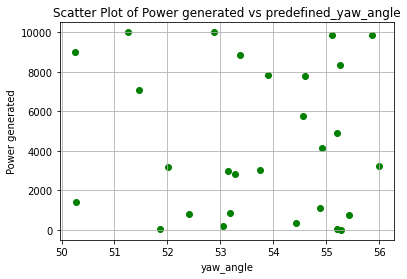

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285]), array([8481.15089699, 8690.54956524]), array([10000.00070502,   224.24670203]), array([9999.

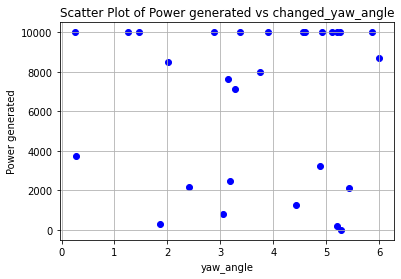

Power_list: [864.7779783214871, 2513.6366376412675]
Predefined Yaw Angle 1: 54.215690417814876
Predefined Yaw Angle 2: 52.52822834968837
Changed Yaw Angle 1: 4.215690417814879
Changed Yaw Angle 2: 2.52822834968837
farm_power_baseline : [1735.98816103 1263.42463723], farm_power_yaw : [4602.96906806 3393.95244309]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]), array([10000.00147919,  4895.813

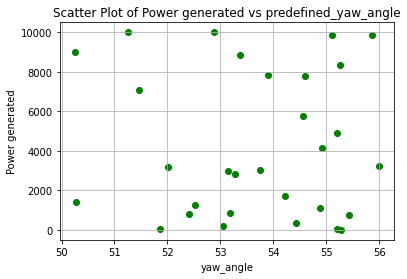

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285]), array([8481.15089699, 8690.54956524]), array([10000.0007050

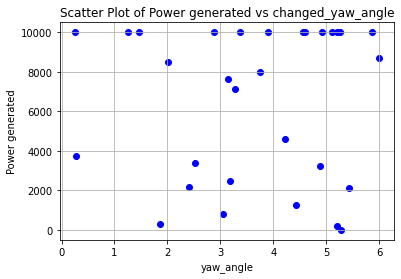

Power_list: [1735.988161033062, 4618.7588793703135]
Predefined Yaw Angle 1: 54.92337381217829
Predefined Yaw Angle 2: 52.77705627876607
Changed Yaw Angle 1: 4.92337381217829
Changed Yaw Angle 2: 2.7770562787660706
farm_power_baseline : [   0.         2098.70520352], farm_power_yaw : [  25.12080423 5634.93165897]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628])]
Power generated list: [array([9852.63948378,  373.30276769]), array([8980.61071451,   62.95885782]

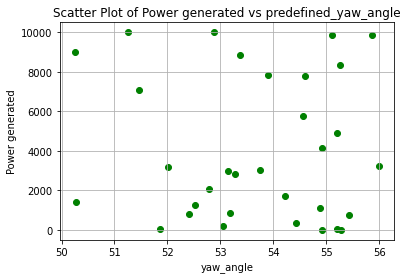

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852285]), array([8481.15089699, 8690

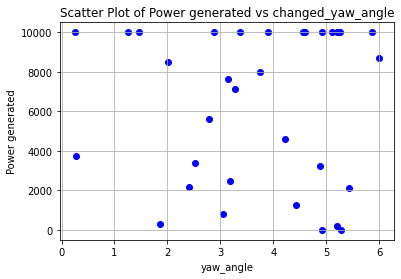

Power_list: [2098.7052035246206, 5659.630689369134]
Predefined Yaw Angle 1: 56.18105589802595
Predefined Yaw Angle 2: 54.85407478767872
Changed Yaw Angle 1: 6.181055898025954
Changed Yaw Angle 2: 4.854074787678718
farm_power_baseline : [3259.76512159  104.14849593], farm_power_yaw : [9308.97340543  520.48857503]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479])]
Power generated list: [array([9852.63948378,  373.30276769]), a

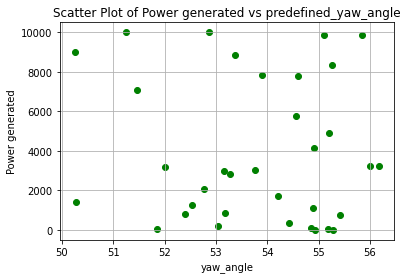

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), array([10000.01003185,  7972.76852

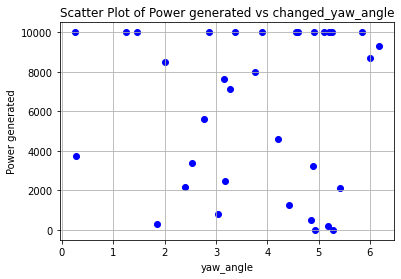

Power_list: [3259.765121587806, 9388.010924981678]
Predefined Yaw Angle 1: 50.76674720308803
Predefined Yaw Angle 2: 55.687471636034886
Changed Yaw Angle 1: 0.7667472030880305
Changed Yaw Angle 2: 5.687471636034882
farm_power_baseline : [9024.98004445 8843.67036649], farm_power_yaw : [10000.00365693 10000.00985447]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164])]
Power generated list: [ar

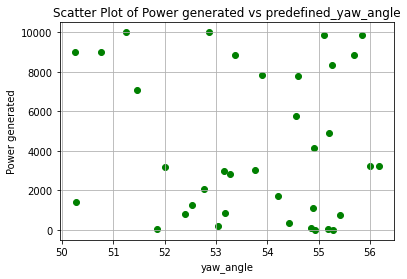

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10000.00888139, 10000.00447965]), a

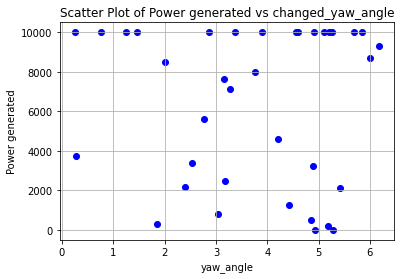

Power_list: [9024.980044445163, 10000.015820075741]
Predefined Yaw Angle 1: 54.330925664498714
Predefined Yaw Angle 2: 54.134710236142
Changed Yaw Angle 1: 4.330925664498717
Changed Yaw Angle 2: 4.134710236142001
farm_power_baseline : [0. 0.], farm_power_yaw : [30.6732288  0.       ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471024])]
Power generated list: 

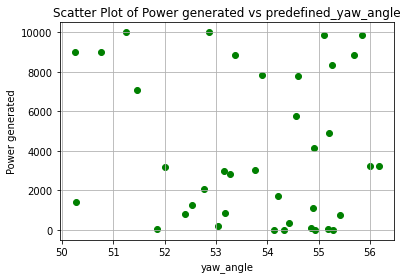

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.92368626, 9999.99916709]), array([10

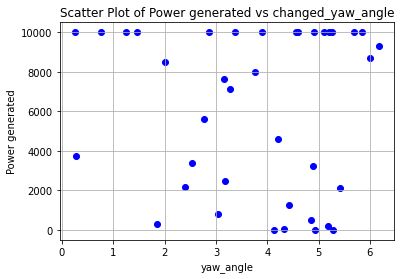

Power_list: [0.0, 31.352127787675258]
Predefined Yaw Angle 1: 52.22534075815334
Predefined Yaw Angle 2: 50.699031361277484
Changed Yaw Angle 1: 2.2253407581533353
Changed Yaw Angle 2: 0.6990313612774833
farm_power_baseline : [3535.6681653   114.92152802], farm_power_yaw : [8537.22034334  448.25834935]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471024]), arra

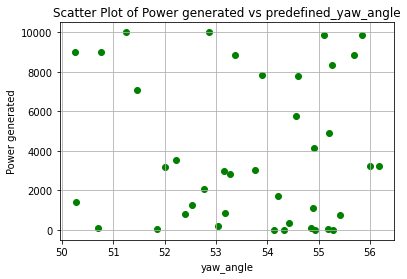

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542, 2127.60893201]), array([ 804.923

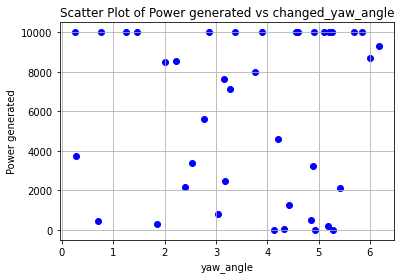

Power_list: [3535.668165298083, 8537.22034334031]
Predefined Yaw Angle 1: 51.17620269462845
Predefined Yaw Angle 2: 50.42148869669433
Changed Yaw Angle 1: 1.1762026946284514
Changed Yaw Angle 2: 0.4214886966943305
farm_power_baseline : [   0.         1164.42647562], farm_power_yaw : [   0.         2835.50965377]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471

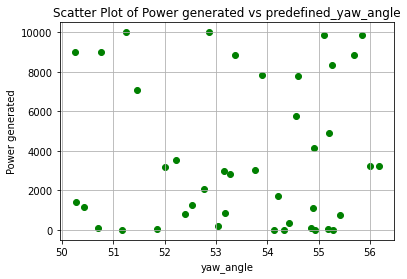

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.10287677]), array([3731.52284542,

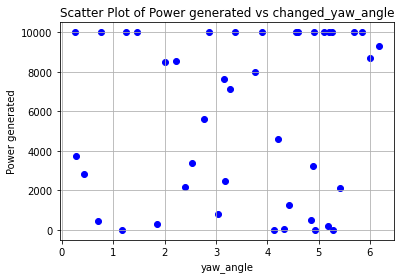

Power_list: [1164.4264756235789, 2836.180872572697]
Predefined Yaw Angle 1: 50.65804595555967
Predefined Yaw Angle 2: 53.99924694939847
Changed Yaw Angle 1: 0.6580459555596749
Changed Yaw Angle 2: 3.999246949398467
farm_power_baseline : [  0.         570.41377667], farm_power_yaw : [  38.34750349 1612.26818729]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134710

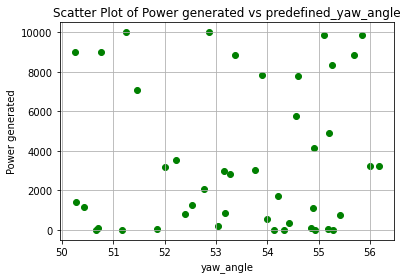

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.00178801]), array([9999.99672456, 7120.

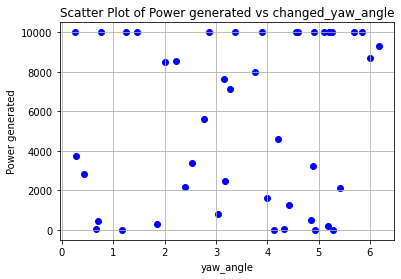

Power_list: [570.4137766678612, 1612.2681872928438]
Predefined Yaw Angle 1: 52.12844816663547
Predefined Yaw Angle 2: 55.15090486382455
Changed Yaw Angle 1: 2.128448166635473
Changed Yaw Angle 2: 5.150904863824551
farm_power_baseline : [2520.71005152 9999.99368946], farm_power_yaw : [ 6680.17896424 10000.01452587]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134

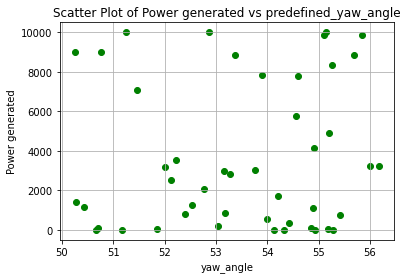

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), array([ 3222.20277809, 10000.001788

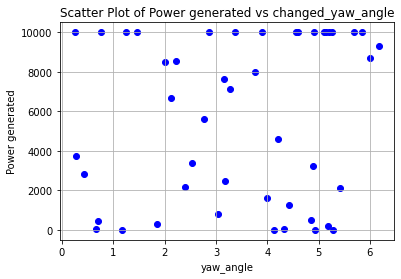

Power_list: [9999.993689455023, 10000.014525865357]
Predefined Yaw Angle 1: 54.65098303272389
Predefined Yaw Angle 2: 52.417548706365224
Changed Yaw Angle 1: 4.650983032723895
Changed Yaw Angle 2: 2.417548706365222
farm_power_baseline : [879.76195395 585.21044958], farm_power_yaw : [2462.09470363 1715.64897335]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134710

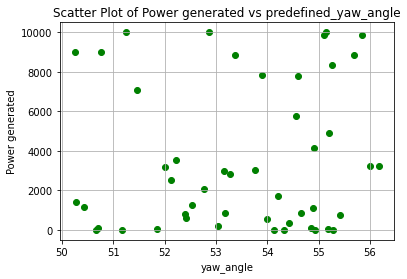

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2193.50226357, 7622.87995836]), ar

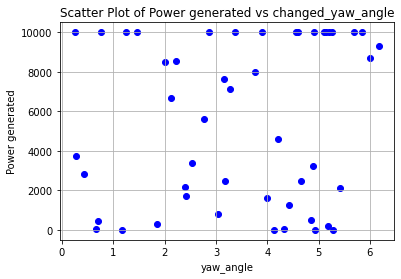

Power_list: [879.761953954313, 2472.061405742729]
Predefined Yaw Angle 1: 53.01876995013403
Predefined Yaw Angle 2: 54.11063978726154
Changed Yaw Angle 1: 3.018769950134027
Changed Yaw Angle 2: 4.110639787261539
farm_power_baseline : [   0.        9999.9966874], farm_power_yaw : [    0.         10000.01415507]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.1347102

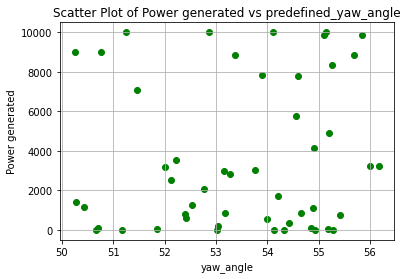

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96037936, 9999.99593533]), array([2

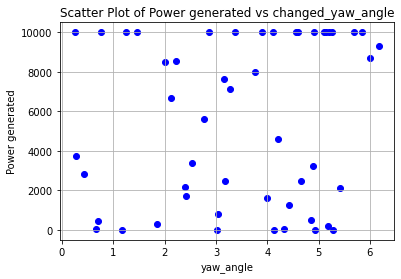

Power_list: [9999.99668740443, 10000.014155068897]
Predefined Yaw Angle 1: 51.41964464671758
Predefined Yaw Angle 2: 54.88711982311664
Changed Yaw Angle 1: 1.4196446467175756
Changed Yaw Angle 2: 4.887119823116639
farm_power_baseline : [   0.         6108.95130563], farm_power_yaw : [    0.         10000.00473894]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134

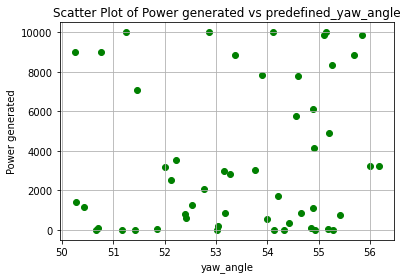

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,   316.03237097]), array([9999.96

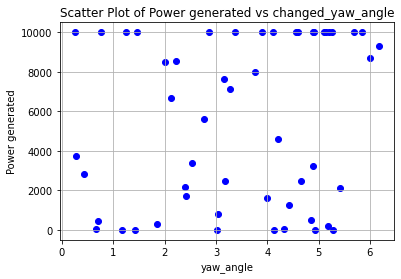

Power_list: [6108.951305629842, 10000.00473893779]
Predefined Yaw Angle 1: 53.08095129947796
Predefined Yaw Angle 2: 53.833465171541036
Changed Yaw Angle 1: 3.08095129947796
Changed Yaw Angle 2: 3.833465171541034
farm_power_baseline : [3121.5722142  8550.75490617], farm_power_yaw : [ 8182.24837693 10000.00237697]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.1347

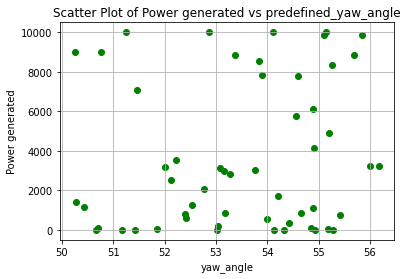

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517])]
Power generated list: [array([9999.98334062, 1241.38936992]), array([10000.00216632,

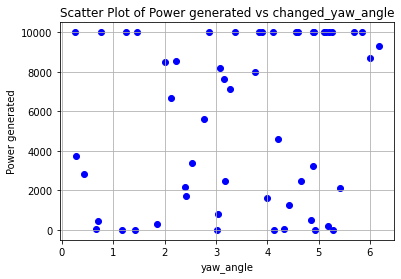

Power_list: [8550.754906170085, 10000.003572429821]
Predefined Yaw Angle 1: 51.46851405219469
Predefined Yaw Angle 2: 56.07736907226684
Changed Yaw Angle 1: 1.468514052194693
Changed Yaw Angle 2: 6.077369072266842
farm_power_baseline : [9999.99827     142.05197877], farm_power_yaw : [10000.00705036   573.03843422]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134

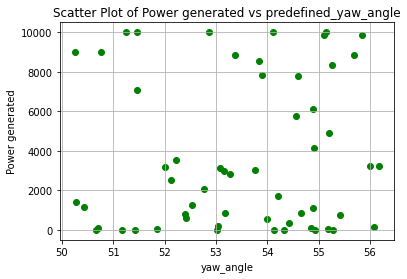

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907])]
Power generated list: [array([9999.98334062, 1241.3

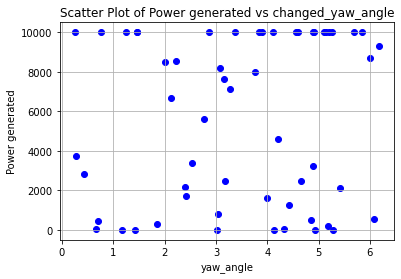

Power_list: [9999.998269996277, 10000.007050357122]
Predefined Yaw Angle 1: 55.04097794065175
Predefined Yaw Angle 2: 52.924548531521275
Changed Yaw Angle 1: 5.040977940651753
Changed Yaw Angle 2: 2.924548531521275
farm_power_baseline : [9246.8847365  9999.99956776], farm_power_yaw : [10000.01141579  9999.9799476 ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

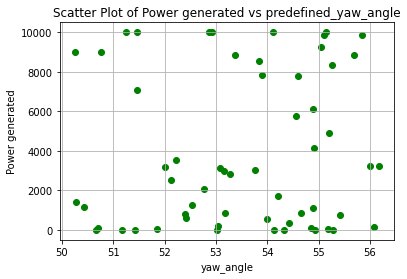

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853])]
Power generated li

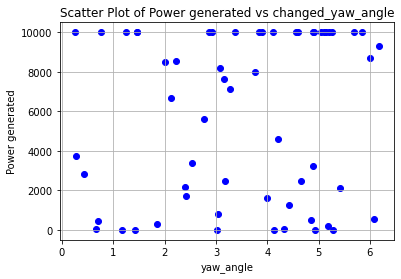

Power_list: [9999.99956776271, 10000.011415789464]
Predefined Yaw Angle 1: 50.12250057220642
Predefined Yaw Angle 2: 53.280623555593124
Changed Yaw Angle 1: 0.12250057220641693
Changed Yaw Angle 2: 3.2806235555931202
farm_power_baseline : [4717.72188108  911.37470081], farm_power_yaw : [9999.99698063 2349.93679538]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

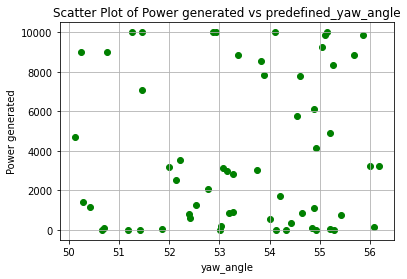

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

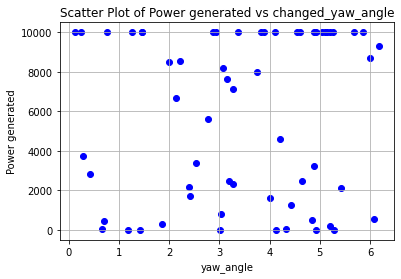

Power_list: [4717.721881084073, 9999.996980627162]
Predefined Yaw Angle 1: 53.831904669968544
Predefined Yaw Angle 2: 56.06527778828566
Changed Yaw Angle 1: 3.8319046699685413
Changed Yaw Angle 2: 6.065277788285665
farm_power_baseline : [9999.99381593  964.40012473], farm_power_yaw : [10000.01414745  2792.10032037]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

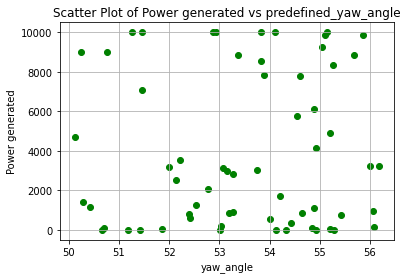

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

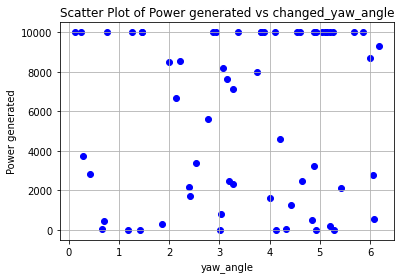

Power_list: [9999.993815927031, 10000.014147450702]
Predefined Yaw Angle 1: 52.03799975916533
Predefined Yaw Angle 2: 54.443891520791404
Changed Yaw Angle 1: 2.03799975916533
Changed Yaw Angle 2: 4.4438915207914045
farm_power_baseline : [710.55611745 923.32265474], farm_power_yaw : [2011.09191649 2539.55828332]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134710

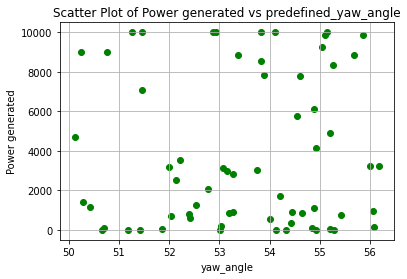

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

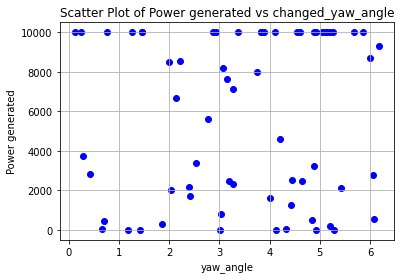

Power_list: [923.3226547412847, 2548.3152988970064]
Predefined Yaw Angle 1: 50.491238494497914
Predefined Yaw Angle 2: 52.67457943791648
Changed Yaw Angle 1: 0.491238494497912
Changed Yaw Angle 2: 2.6745794379164756
farm_power_baseline : [  60.10635    1680.67834697], farm_power_yaw : [ 316.64017347 4132.95535254]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134

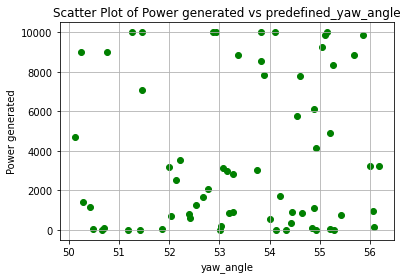

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

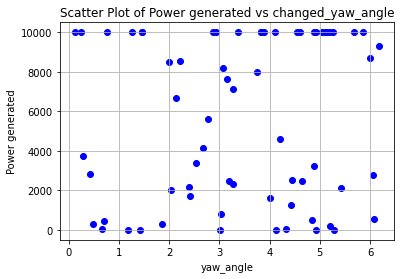

Power_list: [1680.6783469668924, 4137.569298738888]
Predefined Yaw Angle 1: 53.30755142083342
Predefined Yaw Angle 2: 56.16949633648817
Changed Yaw Angle 1: 3.307551420833423
Changed Yaw Angle 2: 6.169496336488172
farm_power_baseline : [2428.5374567  2854.95006216], farm_power_yaw : [6751.17465974 7902.39578764]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471

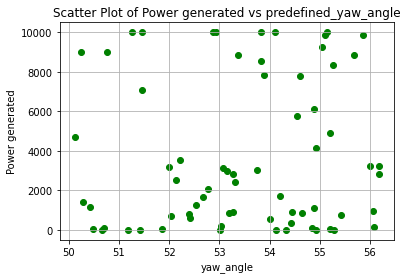

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

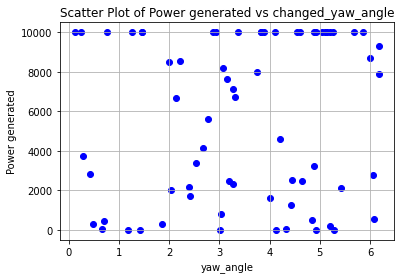

Power_list: [2854.950062161262, 7958.127937626794]
Predefined Yaw Angle 1: 51.952716818945504
Predefined Yaw Angle 2: 53.384491365480066
Changed Yaw Angle 1: 1.9527168189455044
Changed Yaw Angle 2: 3.3844913654800637
farm_power_baseline : [2751.33615152 3688.62973066], farm_power_yaw : [7009.17626465 9317.04383601]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

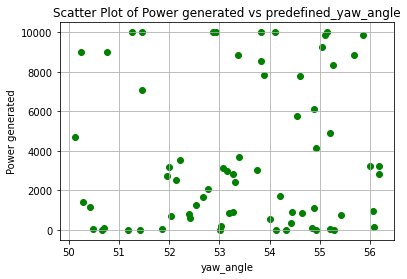

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

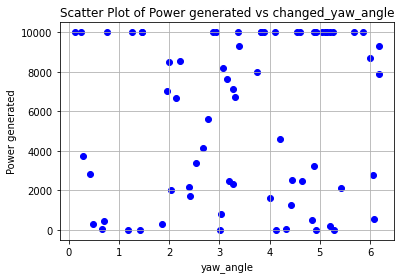

Power_list: [3688.6297306573188, 9336.541688179503]
Predefined Yaw Angle 1: 50.28661404608848
Predefined Yaw Angle 2: 54.216487391102845
Changed Yaw Angle 1: 0.286614046088483
Changed Yaw Angle 2: 4.216487391102847
farm_power_baseline : [4406.1907394  9999.99582127], farm_power_yaw : [ 9999.99362198 10000.0144697 ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

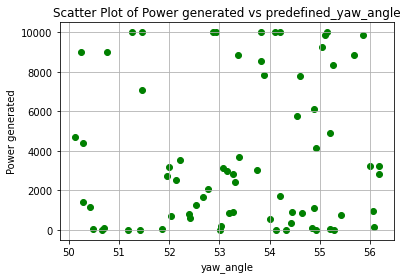

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

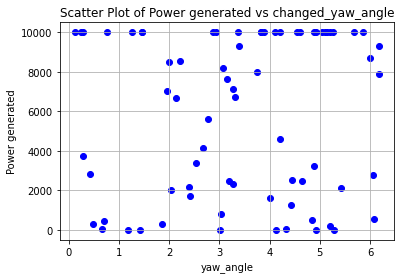

Power_list: [9999.995821268632, 10000.014469700793]
Predefined Yaw Angle 1: 51.37930987358583
Predefined Yaw Angle 2: 51.9761004609126
Changed Yaw Angle 1: 1.3793098735858351
Changed Yaw Angle 2: 1.9761004609125974
farm_power_baseline : [ 972.36438893 9869.61717975], farm_power_yaw : [ 2495.36565542 10000.015972  ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

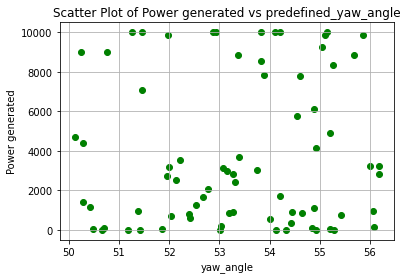

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

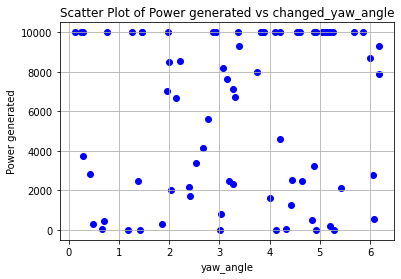

Power_list: [9869.617179751142, 10000.016121180322]
Predefined Yaw Angle 1: 53.37187262011324
Predefined Yaw Angle 2: 54.76069051142287
Changed Yaw Angle 1: 3.3718726201132347
Changed Yaw Angle 2: 4.760690511422871
farm_power_baseline : [7569.62401956  415.63789501], farm_power_yaw : [10000.00404217  1307.06120803]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13

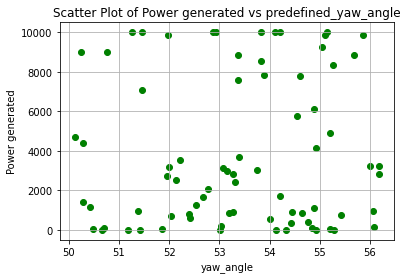

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

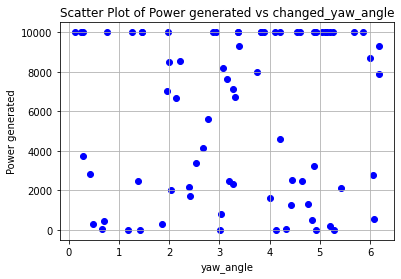

Power_list: [7569.624019555839, 10000.004042165263]
Predefined Yaw Angle 1: 54.53996756478729
Predefined Yaw Angle 2: 55.191376922910486
Changed Yaw Angle 1: 4.539967564787288
Changed Yaw Angle 2: 5.191376922910486
farm_power_baseline : [563.87191945   0.        ], farm_power_yaw : [1764.09050509    0.        ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134710

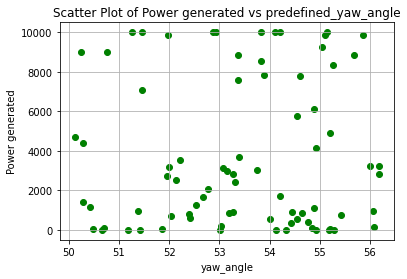

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

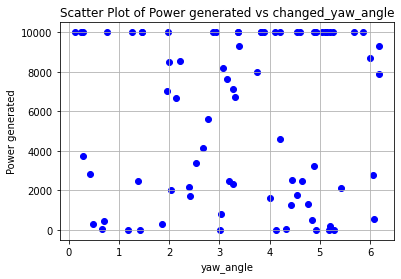

Power_list: [563.8719194450642, 1775.947268175381]
Predefined Yaw Angle 1: 53.25292625845037
Predefined Yaw Angle 2: 52.58465114580723
Changed Yaw Angle 1: 3.2529262584503718
Changed Yaw Angle 2: 2.584651145807225
farm_power_baseline : [ 2792.61852795 10000.00580605], farm_power_yaw : [7191.48534769 9999.96034606]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.134

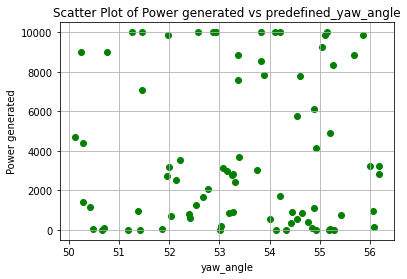

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

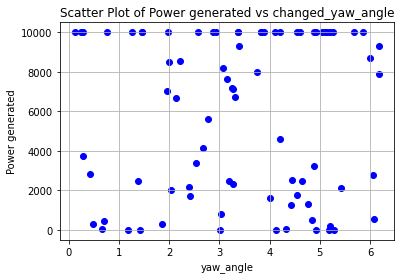

Power_list: [10000.005806051846, 9999.960346061944]
Predefined Yaw Angle 1: 53.35155563047313
Predefined Yaw Angle 2: 51.12809098081322
Changed Yaw Angle 1: 3.3515556304731295
Changed Yaw Angle 2: 1.1280909808132227
farm_power_baseline : [  0.         969.82124172], farm_power_yaw : [   0.         2548.16060183]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471

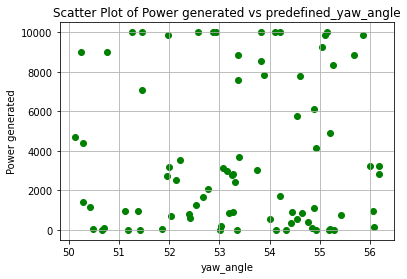

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

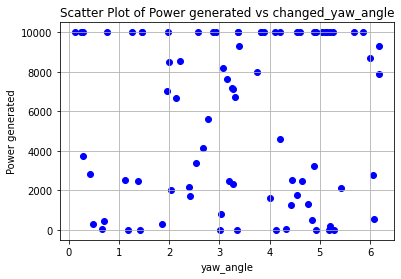

Power_list: [969.8212417193669, 2552.7448802424756]
Predefined Yaw Angle 1: 55.692638545692034
Predefined Yaw Angle 2: 50.09252545146782
Changed Yaw Angle 1: 5.692638545692038
Changed Yaw Angle 2: 0.0925254514678187
farm_power_baseline : [448.48786267   0.        ], farm_power_yaw : [1322.76805438    0.        ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471

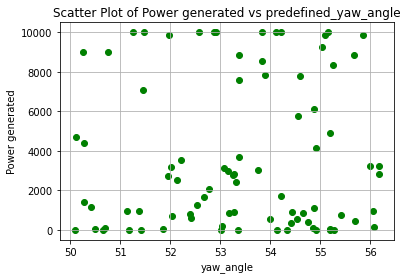

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

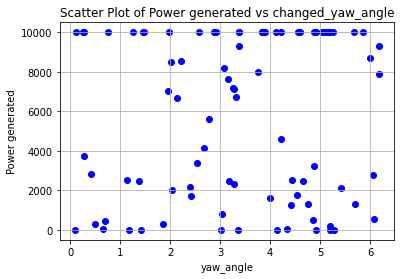

Power_list: [448.48786266856547, 1329.075447736526]
Predefined Yaw Angle 1: 53.52190579486448
Predefined Yaw Angle 2: 53.919834415169504
Changed Yaw Angle 1: 3.521905794864484
Changed Yaw Angle 2: 3.919834415169503
farm_power_baseline : [ 530.34776924 3390.43890675], farm_power_yaw : [1597.44305812 8979.70931052]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.1347

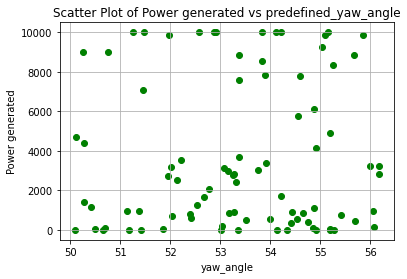

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

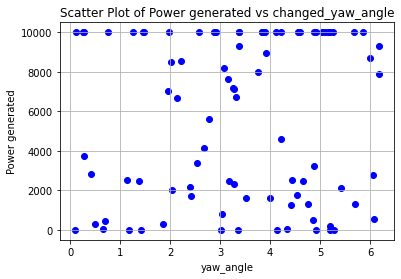

Power_list: [3390.4389067510147, 8979.70931051865]
Predefined Yaw Angle 1: 54.13561635437114
Predefined Yaw Angle 2: 51.96288758663833
Changed Yaw Angle 1: 4.13561635437114
Changed Yaw Angle 2: 1.9628875866383328
farm_power_baseline : [759.35047107 921.99340119], farm_power_yaw : [2105.95062038 2500.95049036]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471024

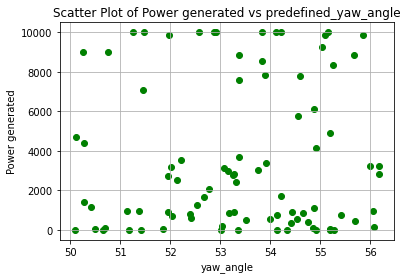

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

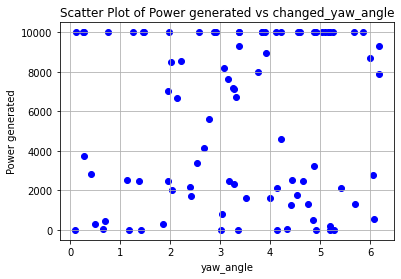

Power_list: [921.993401191839, 2523.2342518625805]
Predefined Yaw Angle 1: 54.91230677995236
Predefined Yaw Angle 2: 56.06070673859065
Changed Yaw Angle 1: 4.912306779952356
Changed Yaw Angle 2: 6.060706738590653
farm_power_baseline : [   0.         8042.35913421], farm_power_yaw : [   59.79933309 10000.00676782]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.1347

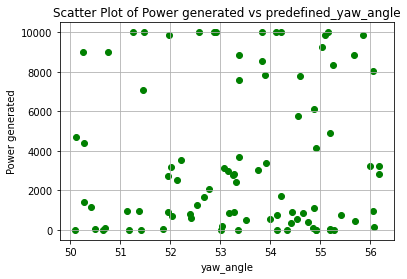

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

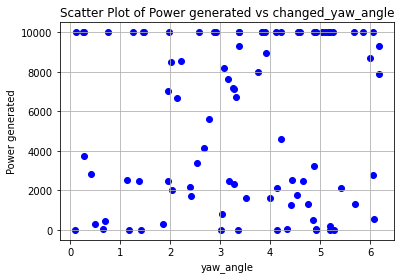

Power_list: [8042.359134214909, 10000.008308662853]
Predefined Yaw Angle 1: 53.46196150083622
Predefined Yaw Angle 2: 50.06284052637725
Changed Yaw Angle 1: 3.4619615008362175
Changed Yaw Angle 2: 0.06284052637725046
farm_power_baseline : [2233.71940618 9999.99753754], farm_power_yaw : [ 5493.40930799 10000.01441222]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.

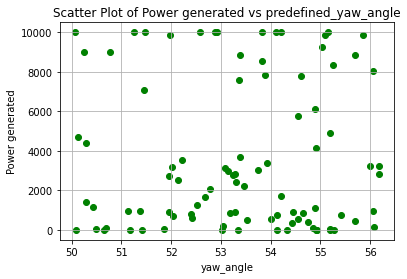

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

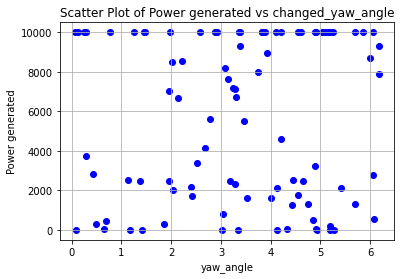

Power_list: [9999.997537537785, 10000.01441221984]
Predefined Yaw Angle 1: 55.88600161769499
Predefined Yaw Angle 2: 52.79212790632316
Changed Yaw Angle 1: 5.886001617694985
Changed Yaw Angle 2: 2.792127906323156
farm_power_baseline : [8121.99414889   72.27730539], farm_power_yaw : [10000.00095381   407.05534548]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.1347

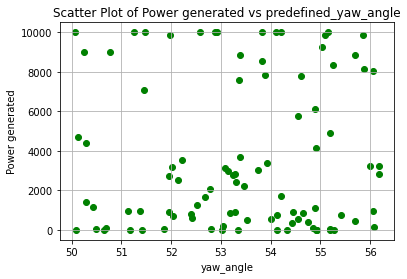

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

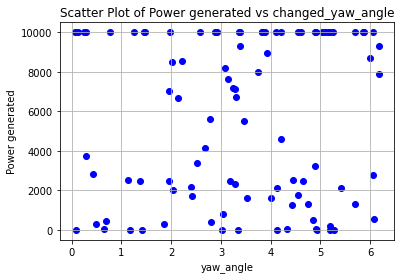

Power_list: [8121.994148886835, 10000.000953805924]
Predefined Yaw Angle 1: 51.50516420880025
Predefined Yaw Angle 2: 52.08113367009256
Changed Yaw Angle 1: 1.5051642088002546
Changed Yaw Angle 2: 2.0811336700925596
farm_power_baseline : [1061.4646539    0.       ], farm_power_yaw : [2723.78169391   61.9492916 ]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471

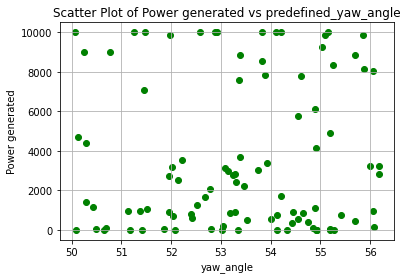

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

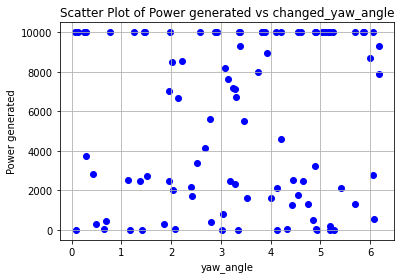

Power_list: [1061.4646539019254, 2726.2544725923267]
Predefined Yaw Angle 1: 53.89446019344563
Predefined Yaw Angle 2: 50.55848410001299
Changed Yaw Angle 1: 3.8944601934456307
Changed Yaw Angle 2: 0.5584841000129875
farm_power_baseline : [0. 0.], farm_power_yaw : [53.37641248 35.34050177]
Predefined_yaw_angle list: [array([55.10058002, 54.42107622]), array([50.25067352, 51.85158783]), array([51.25244593, 55.19426858]), array([52.40295922, 53.1500525 ]), array([54.88689809, 54.60172643]), array([51.45922441, 53.28083608]), array([50.27958397, 55.41997202]), array([53.04072372, 55.85266379]), array([55.25716164, 54.55514188]), array([53.37616297, 53.75320628]), array([52.00749391, 55.99492613]), array([53.89562027, 55.19331251]), array([54.91807039, 52.87493464]), array([55.27489243, 53.18562594]), array([54.21569042, 52.52822835]), array([54.92337381, 52.77705628]), array([56.1810559 , 54.85407479]), array([50.7667472 , 55.68747164]), array([54.33092566, 54.13471024]), array([52.225340

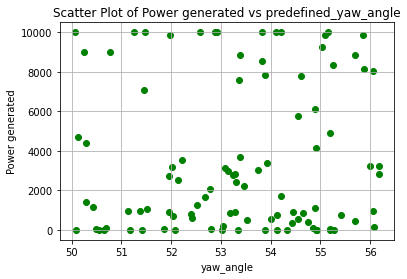

Changed_yaw_angle list: [array([5.10058002, 4.42107622]), array([0.25067352, 1.85158783]), array([1.25244593, 5.19426858]), array([2.40295922, 3.1500525 ]), array([4.88689809, 4.60172643]), array([1.45922441, 3.28083608]), array([0.27958397, 5.41997202]), array([3.04072372, 5.85266379]), array([5.25716164, 4.55514188]), array([3.37616297, 3.75320628]), array([2.00749391, 5.99492613]), array([3.89562027, 5.19331251]), array([4.91807039, 2.87493464]), array([5.27489243, 3.18562594]), array([4.21569042, 2.52822835]), array([4.92337381, 2.77705628]), array([6.1810559 , 4.85407479]), array([0.7667472 , 5.68747164]), array([4.33092566, 4.13471024]), array([2.22534076, 0.69903136]), array([1.17620269, 0.4214887 ]), array([0.65804596, 3.99924695]), array([2.12844817, 5.15090486]), array([4.65098303, 2.41754871]), array([3.01876995, 4.11063979]), array([1.41964465, 4.88711982]), array([3.0809513 , 3.83346517]), array([1.46851405, 6.07736907]), array([5.04097794, 2.92454853]), array([0.12250057,

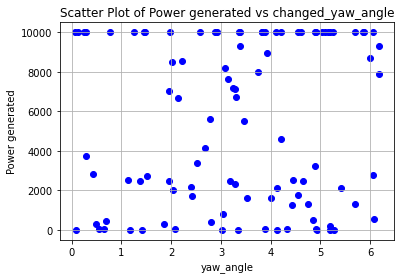

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Power_list: [0.0, 91.5549007105802]
0.0001502037 359.72635
Predefined Yaw Angle 1: 49.94517148598759
Predefined Yaw Angle 2: 56.168746922957425
Changed Yaw Angle 1: -0.0548285140124095
Changed Yaw Angle 2: 6.168746922957424
Wind_Direction:  3.1300549507141113

Speed1:  5.257175445556641
 
Speed2:  16.905635833740234
 
Turbulance Intensity:  0.8635000586509705
 
Vear:  0.6490046381950378
 
Sheer:  0.2737269401550293
 
Episode:  1 Score:  -1
------------------------------------
0.0 360.0
Predefined Yaw Angle 1: 49.94516886443839
Predefined Yaw Angle 2: 56.17352303605637
Changed Yaw Angle 1: -0.05483113556160755
Changed Yaw Angle 2: 6.1735230360563715
Wind_Direction:  289.9530944824219

Speed1:  14.708022117614746
 
Speed2:  9.576346397399902
 
Turbulance Intensity:  0.9465189576148987
 
Vear:  -0.2739463448524475
 
Sheer:  0.01254366897046566
 
Episode:  2 Score:  -2
------------------------------------
0.0 360.0
Predefined Yaw Angle 1: 49.94516886443839
Predefined Yaw Angle 2: 56.173523

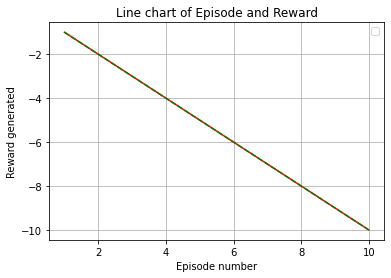

Mean of Predefined Yaw Power:  -5.5
Mean of Changed Yaw Power:  -5.5
StdDev of Predefined Yaw Power 3.0276503540974917
StdDev of Changed Yaw Power 3.0276503540974917


In [6]:


model = SAC(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50)
model.save("sac_wind_farm")

#del model remove to demonstrate saving and loading

#model = SAC.load("sac_wind_farm")

obs = env.reset()

episodes = 10
#done = False
ep_list = [i for i in range(1,11)]
score1 = 0
score2 = 0
rew = []
base_power = []
for episode in range(1, episodes+1):
    obs = env.reset() 
    #done = False
    #score = 0
    action, _states = model.predict(obs)
    print(action[0],action[1])
    obs, reward, done, info = env.step(action)
    #wind_direction - obs[0]
    #speed1 - obs[1]
    #speed2 - obs[2]
    #TI - obs[3]
    #vear - obs[4]
    #sheer - obs[5]
    print('Wind_Direction:  {}\n'.format(obs[0]))
    print('Speed1:  {}\n '.format(obs[1]))
    print('Speed2:  {}\n '.format(obs[2]))
    print('Turbulance Intensity:  {}\n '.format(obs[3]))
    print('Vear:  {}\n '.format(obs[4]))
    print('Sheer:  {}\n '.format(obs[5]))
    if done==True:
        break
    else:
        score1+=reward
        rew.append(score1)
        score2+=info.get('power')
        base_power.append(score2)
        
    print('Episode:  {} Score:  {}'.format(episode, score1))
    print("------------------------------------")

print('Predefined Yaw max power list:',base_power)
print('Changed Yaw max Power list:',rew)
plt.plot(ep_list, rew, color ="red")
plt.plot(ep_list,base_power,'--',color = "green")
plt.title('Line chart of Episode and Reward')
plt.xlabel('Episode number')
plt.ylabel('Reward generated')
plt.legend()
plt.grid()
plt.show()
print("Mean of Predefined Yaw Power: ",statistics.mean(base_power))
print("Mean of Changed Yaw Power: ",statistics.mean(base_power))
print("StdDev of Predefined Yaw Power",statistics.stdev(rew))
print("StdDev of Changed Yaw Power",statistics.stdev(rew))